In [29]:
%%html
<style>
    .dothis{
    font-weight: bold;
    color: #ff7f0e;
    font-size:large
    }
</style>

# Glacier mapping by means of band math

*****

This notebook demonstrates how we can use Python to do the same glacier mapping that we earlier carried out in QGIS.

There are several points at which you will need to modify a line of code. These are identified by <span class='dothis'>bold orange text</span>.


### Reading the data

We start with a few preparation such as reading all the packages we use in the processing.

In [2]:
%load_ext autoreload
%autoreload 2


import time
import psutil
import dask.distributed
import rioxarray
import numpy as np
import xarray as xr
from pystac_client import Client
import matplotlib.pyplot as plt
import pandas as pd 
from sdc_utilities import get_alias_band, load_product_ts
# from sdc_utilities import *


# silence warning (not recommended during development)
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Change the size of the figures displayed in the notebooks: units are inches, order is (width, height).
plt.rcParams['figure.figsize'] = (16,8)  

# Initiate Dask Env
client = dask.distributed.Client()
# display(client)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: No module named 'pystac_client'

**The next cell contains the dataset configuration information, which we have already made for you using the [config_tool-SwissDC](config_tool-SwissDC.ipynb) notebook. This ensures that you will have data well suited to map glacier extent.**

**To make this notebook run you will need to use anyone of Landsat or Sentinel 2 products with the red green and blue bands, as well as at least one swir band.**

In [31]:

product = 'landsat_ot_c2_l2'
measurements = ['QA_PIXEL', 'blue', 'green', 'red', 'nir', 'swir_1', 'swir_2']
get_alias_band(product, measurements, measurements_file='measurements_SwissDC.csv')

Product: landsat_ot_c2_l2
  measurement     alias
0       SR_B2      blue
1       SR_B3     green
2       SR_B4       red
3       SR_B5       nir
4       SR_B6    swir_1
5       SR_B7    swir_2
6    QA_PIXEL  QA_PIXEL


(['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'QA_PIXEL'],
 ['blue', 'green', 'red', 'nir', 'swir_1', 'swir_2', 'QA_PIXEL'])

In [32]:
# Configuration
catalog = Client.open("https://explorer.swissdatacube.org/stac")

# the below are already run above 
# product = 'landsat_ot_c2_l2'

# you can use either specify the real measurement names or the aliases (https://explorer.swissdatacube.org/products/landsat_ot_c2_l2)
aliases = ['QA_PIXEL', 'blue', 'green', 'red', 'nir', 'swir_1', 'swir_2']
measurements, aliases = get_alias_band(product,measurements, measurements_file="measurements_SwissDC.csv")

longitude = (7.73228, 7.957461) #start and stop
latitude = (45.877007, 46.022142)
crs = 'epsg:4326'

time = ('2016-08-01', '2016-09-30')
# the following date formats are also valid:
# time = ('2000-01-01', '2001-12-31')
# time=('2000-01', '2001-12')
# time=('2000', '2001')

output_crs = 'epsg:2056'
resolution = -30.0, 30.0

Product: landsat_ot_c2_l2
  measurement     alias
0       SR_B2      blue
1       SR_B3     green
2       SR_B4       red
3       SR_B5       nir
4       SR_B6    swir_1
5       SR_B7    swir_2
6    QA_PIXEL  QA_PIXEL



****

__In the following we are using `load_product_ts()` to load the data. There is also a function to mask out cloud obscured values using the pixel quality bands (`QA_PIXEL` in Landsat and `SLC` in Sentinel). We see later more on this.__

Here we are using `load_product_ts` because the cloud masking does not work in the mountains where snow and ice get confused with clouds. 

**However, this means we now have to look at the scenes and manually decide which ones are cloud free.**

****

In [33]:
dataset_in = load_product_ts(catalog = catalog,
                          product = product,
                          time = time,
                          longitude = longitude,
                          latitude = latitude,
                          measurements = measurements,
                          output_crs = output_crs,
                          resolution = resolution,
                          rename = True,               # This will overwrite the band names with the aliases names ...
                          alias_names = aliases,        # ... that need to be specified here in that case.
                          )

In [34]:
dataset_in

<xarray.Dataset> Size: 62MB
Dimensions:      (y: 542, x: 586, time: 7)
Coordinates:
  * y            (y) float64 4kB 1.097e+06 1.097e+06 ... 1.081e+06 1.081e+06
  * x            (x) float64 5kB 2.623e+06 2.623e+06 ... 2.64e+06 2.64e+06
  * time         (time) datetime64[ns] 56B 2016-08-09T10:10:45 ... 2016-09-26...
    spatial_ref  int32 4B 2056
Data variables:
    blue         (time, y, x) float32 9MB nan nan nan ... 1.06e+04 1.15e+04
    green        (time, y, x) float32 9MB nan nan nan ... 1.242e+04 1.336e+04
    red          (time, y, x) float32 9MB nan nan nan ... 1.29e+04 1.392e+04
    nir          (time, y, x) float32 9MB nan nan nan ... 2.234e+04 2.171e+04
    swir_1       (time, y, x) float32 9MB nan nan nan ... 2.281e+04 2.35e+04
    swir_2       (time, y, x) float32 9MB nan nan nan ... 1.832e+04 1.967e+04
    QA_PIXEL     (time, y, x) float32 9MB 1.0 1.0 1.0 ... 2.182e+04 2.182e+04

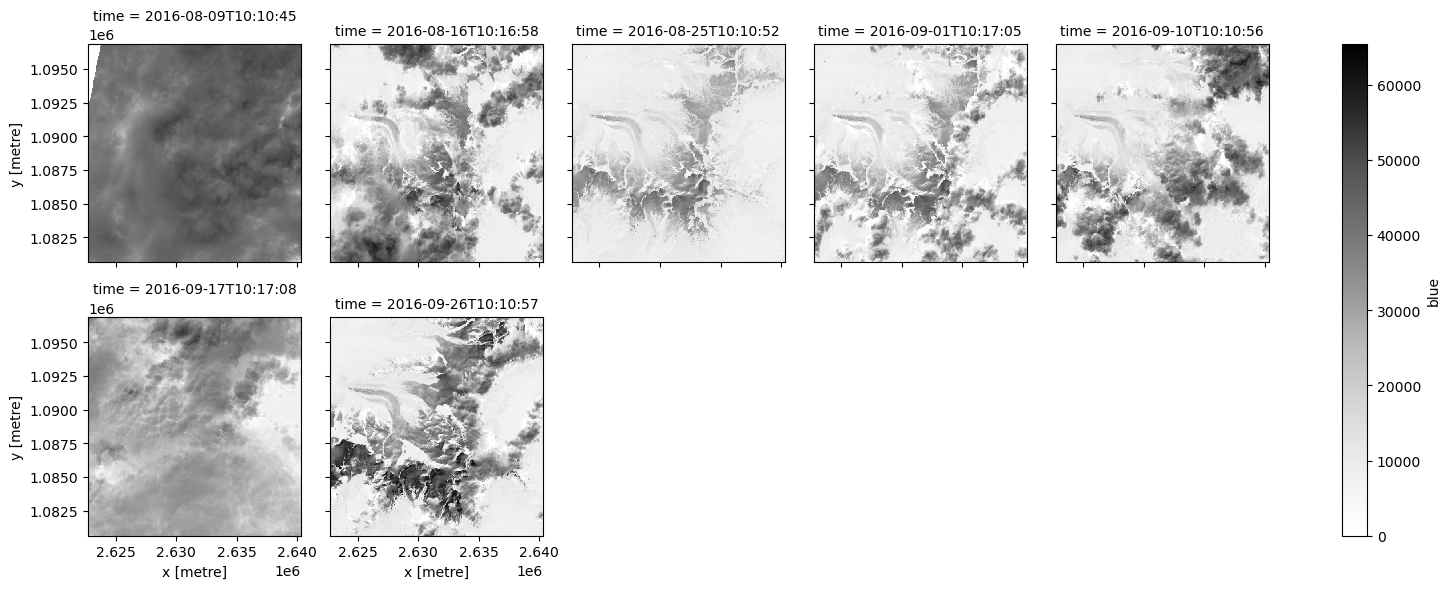

In [35]:
# plot the xarray.Dataset to get an overview of the different scenes along the time axis
dataset_in.blue.plot(col='time', col_wrap=5, cmap='Greys', vmin=0)

### Selecting a cloud free scene

As mentioned before, we have used the `dc.load()` function which does not mask cloud covered areas. 

<span class='dothis'>We now have to plot all time steps again and then visually define which of the scenes is cloud free.</span>

This is best done by visualizing composites, either true color or false color. In the following we first visualize the data in true color, followed by two examples of popular false color visualization for Landsat data.

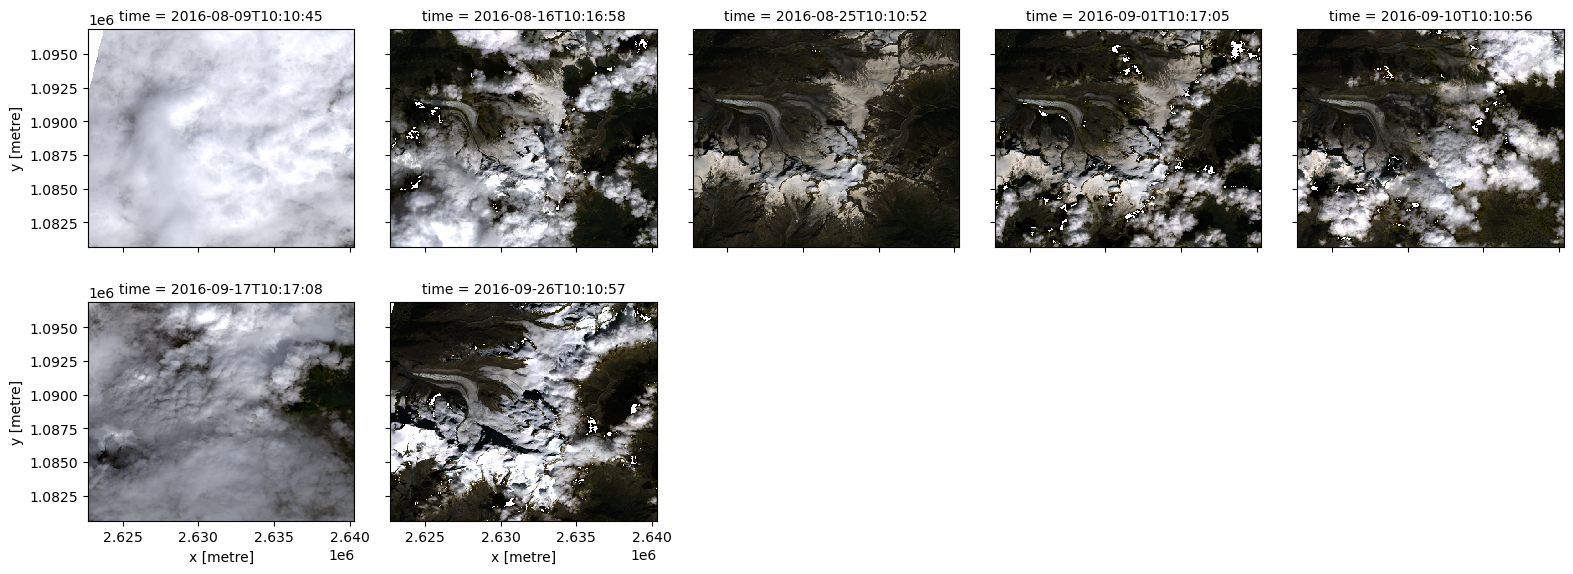

In [36]:
# Let's plot composites in True color (red, green, blue)
# robust=True guesses the minimum and maximum values for each image.
dataset_in[['red','green','blue']].to_array().plot.imshow(col='time',col_wrap=5, robust=True)

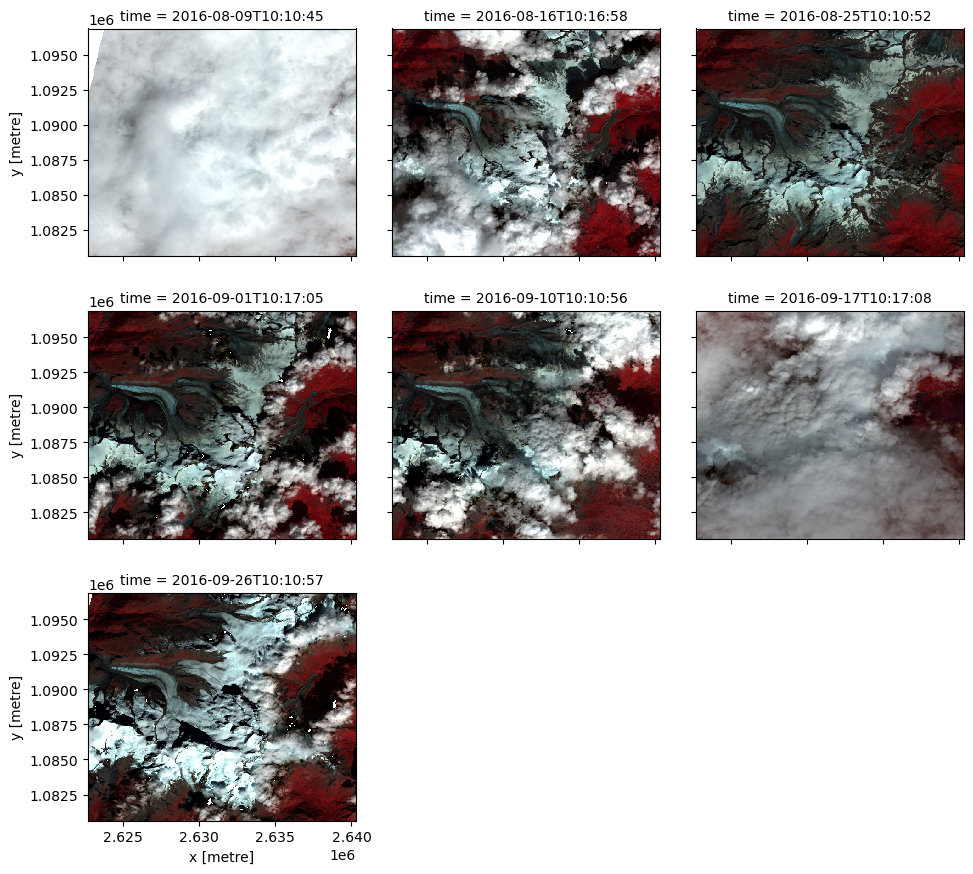

In [37]:
# Let's plot composites in False color (nir, red, green)
dataset_in[['nir','red', 'green']].to_array().plot.imshow(col='time',col_wrap=3, robust=True)

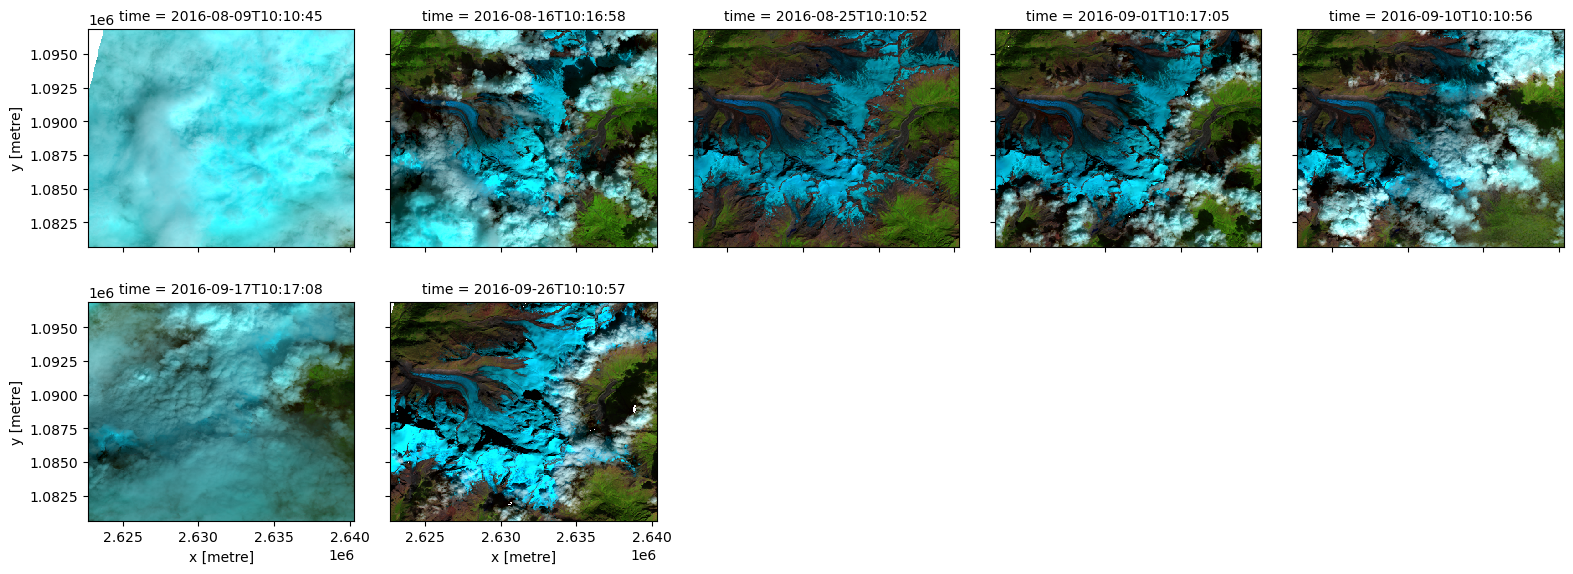

In [38]:
# Let's plot composites in another false color combination, this time (swir1, nir, red) which is well suited to see ice and snow
dataset_in[['swir_1','nir', 'red']].to_array().plot.imshow(col='time',col_wrap=5, robust=True)

Regardless of which visualization we work with, we see that from the seven scenes, only one appears cloud free: **2016-08-25T10:10:52**. We continue working only with that scene.

In [39]:
# Let's select the image we are interested in and save it to a new variable.
# To do this we provide the date of the image we selected above 
# The squeeze() command removes the time dimension from the DataArray, so you are left with two dimensions: latitude and longitude.
mosaic = dataset_in.sel(time='2016-08-25').squeeze()
mosaic

<xarray.Dataset> Size: 9MB
Dimensions:      (y: 542, x: 586)
Coordinates:
  * y            (y) float64 4kB 1.097e+06 1.097e+06 ... 1.081e+06 1.081e+06
  * x            (x) float64 5kB 2.623e+06 2.623e+06 ... 2.64e+06 2.64e+06
    spatial_ref  int32 4B 2056
    time         datetime64[ns] 8B 2016-08-25T10:10:52
Data variables:
    blue         (y, x) float32 1MB nan nan nan ... 1.002e+04 1.023e+04
    green        (y, x) float32 1MB nan nan nan ... 1.141e+04 1.18e+04 1.221e+04
    red          (y, x) float32 1MB nan nan nan ... 1.198e+04 1.247e+04
    nir          (y, x) float32 1MB nan nan nan ... 2.154e+04 2.078e+04
    swir_1       (y, x) float32 1MB nan nan nan ... 2.154e+04 2.194e+04
    swir_2       (y, x) float32 1MB nan nan nan ... 1.71e+04 1.762e+04 1.819e+04
    QA_PIXEL     (y, x) float32 1MB 1.0 1.0 1.0 ... 2.182e+04 2.182e+04

<a id='mosaic_plot'> </a>
Plot mosaic the default way.

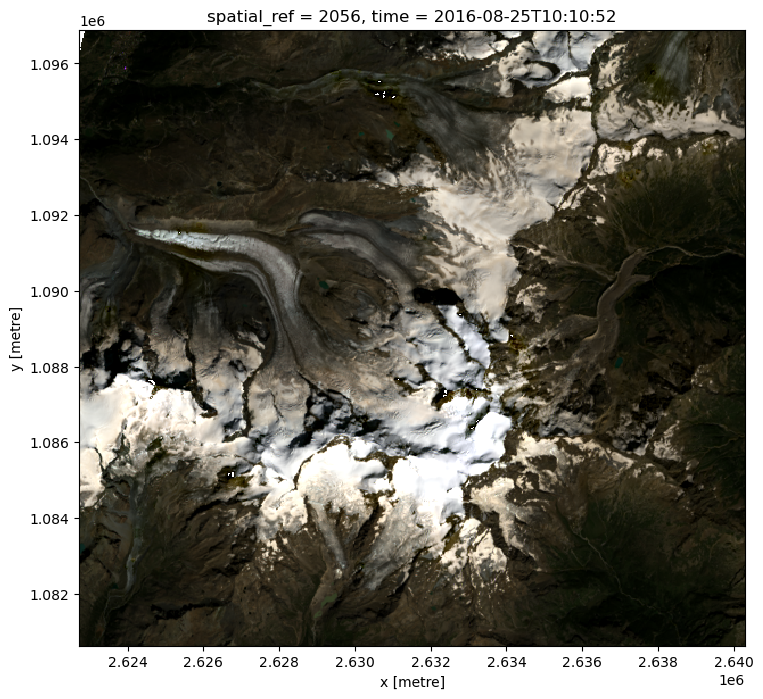

In [40]:

# To do this we need to provide the list of bands we are interested in.
mosaic[['red','green','blue']].to_array().plot.imshow(robust=True)
plt.gca().set_aspect('equal')

In [41]:
mosaic

<xarray.Dataset> Size: 9MB
Dimensions:      (y: 542, x: 586)
Coordinates:
  * y            (y) float64 4kB 1.097e+06 1.097e+06 ... 1.081e+06 1.081e+06
  * x            (x) float64 5kB 2.623e+06 2.623e+06 ... 2.64e+06 2.64e+06
    spatial_ref  int32 4B 2056
    time         datetime64[ns] 8B 2016-08-25T10:10:52
Data variables:
    blue         (y, x) float32 1MB nan nan nan ... 1.002e+04 1.023e+04
    green        (y, x) float32 1MB nan nan nan ... 1.141e+04 1.18e+04 1.221e+04
    red          (y, x) float32 1MB nan nan nan ... 1.198e+04 1.247e+04
    nir          (y, x) float32 1MB nan nan nan ... 2.154e+04 2.078e+04
    swir_1       (y, x) float32 1MB nan nan nan ... 2.154e+04 2.194e+04
    swir_2       (y, x) float32 1MB nan nan nan ... 1.71e+04 1.762e+04 1.819e+04
    QA_PIXEL     (y, x) float32 1MB 1.0 1.0 1.0 ... 2.182e+04 2.182e+04

In [42]:
# Now export to a GeoTIFF file.
mosaic[['red','green','blue']].astype('int32').rio.to_raster("glaciers.tif", driver="COG")



### Band math for glacier detection

*****

We now detect glacier surfaces using the band math: *G = Red / Swir*

Thereby a threshold needs to be defined to distinguish glaciers from non-glacierized terrain.

In [43]:
G = mosaic.red / mosaic.swir_1

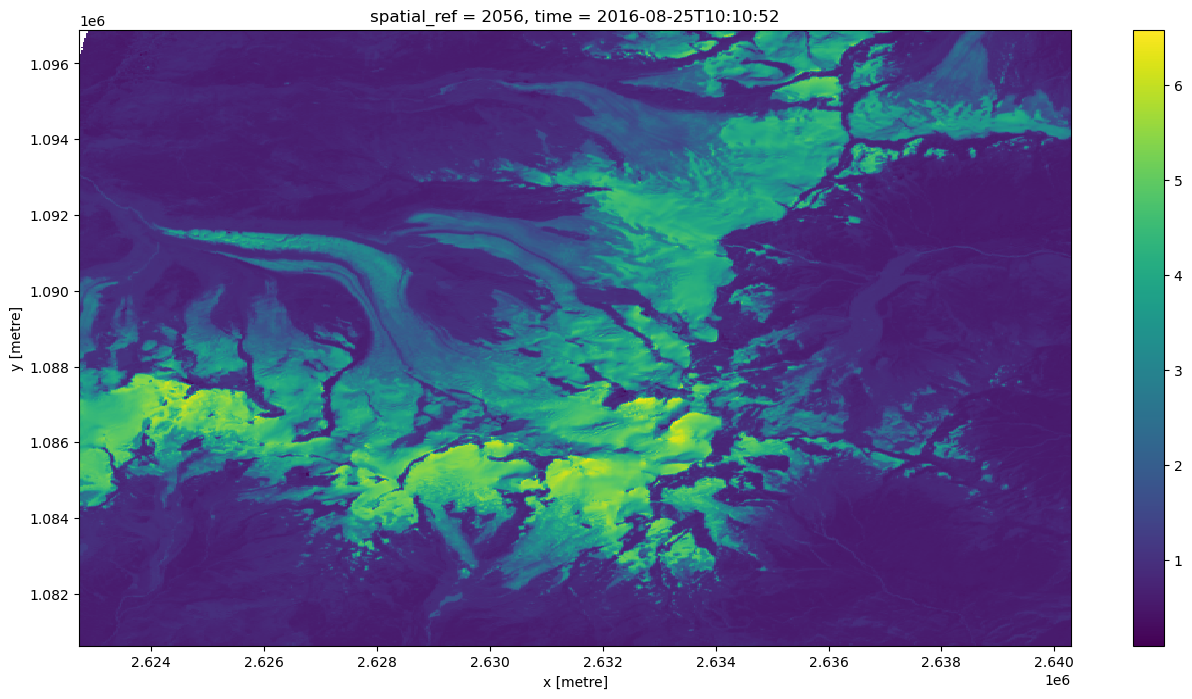

In [44]:
# ratio between channels Red and SWIR where SWIR snow is dark 
G.plot()

We can (or can not) recognize the result. Maybe we can improve the extent of the automatically generated scale. 

It seems that inside the dataset there might be one or a few pixels with extreme values (either artifacts or values indicating invalid pixels). These outliers result in the automated choice of the data range. 

The easy way to visualize the data while ignoring the outliers is to pass the parameter robust=True. This will use the 2nd and 98th percentiles of the data to compute the color limits.

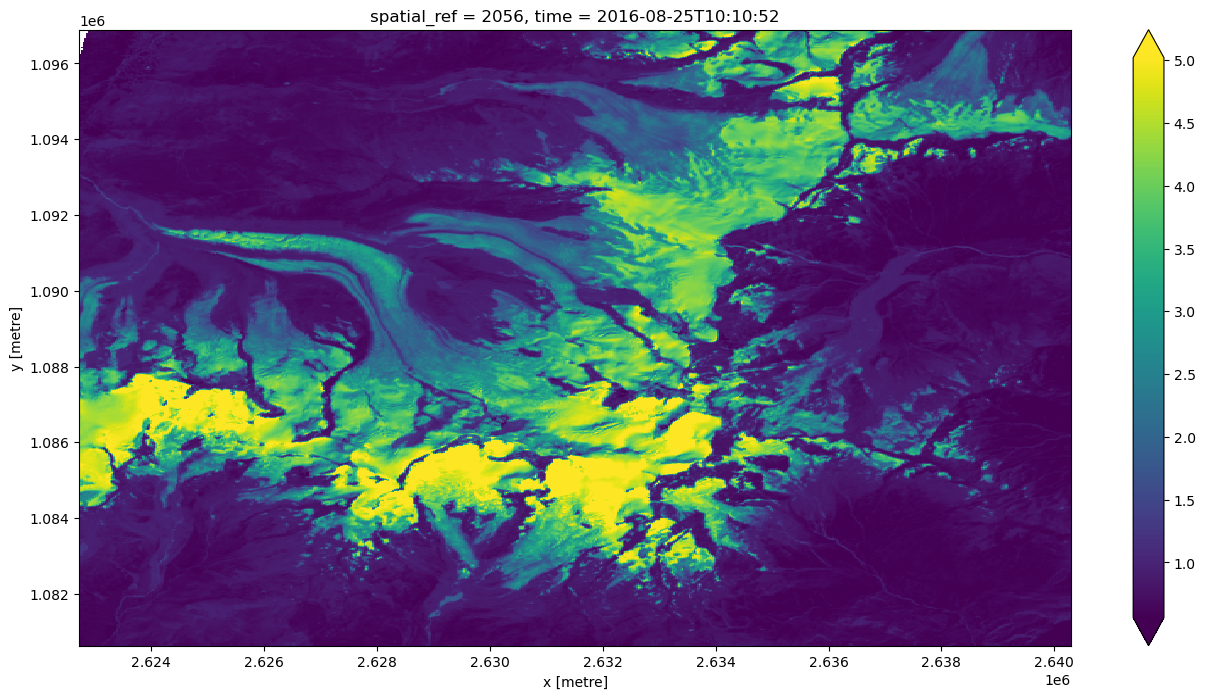

In [45]:
# highest or lower regular value? how to acount for outsiers! 

G.plot(robust=True)

**Note how the color palette has changed.** This is simply because the `DataArray.plot()` function we are using tries to automatically define the optimal colormap. 

We can suppress this behaviour by specifying a colormap from https://matplotlib.org/stable/gallery/color/colormap_reference.html

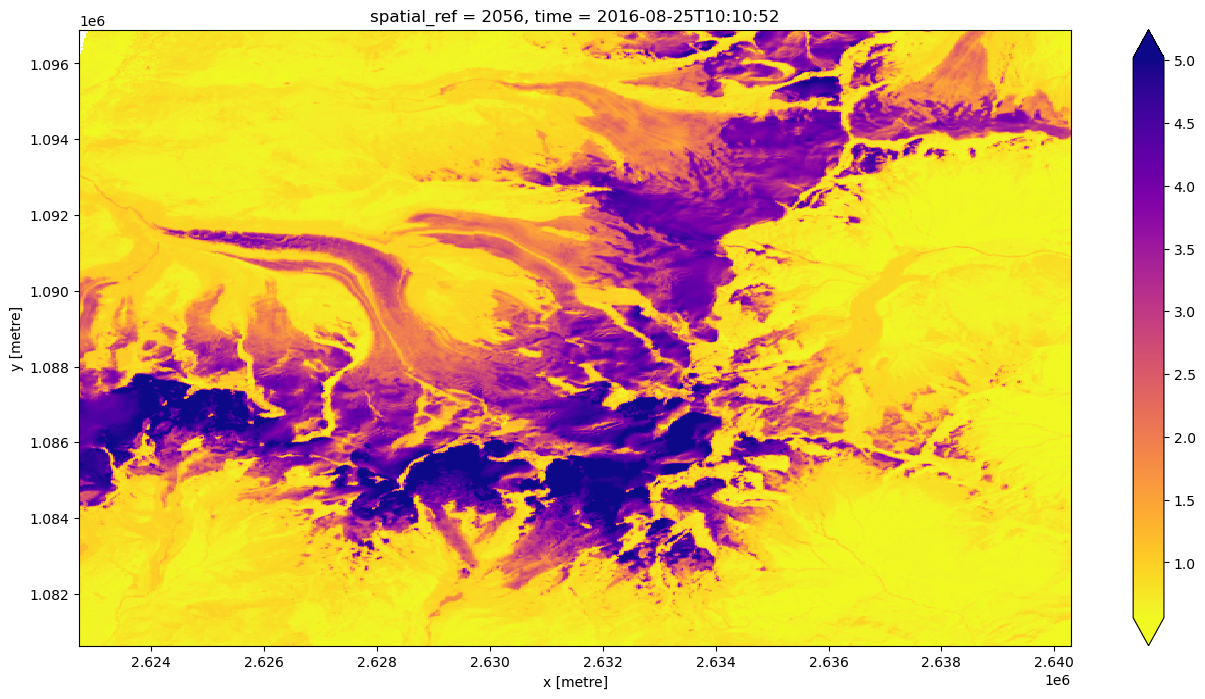

In [46]:
G.plot(robust=True, cmap='plasma_r')

Now let's try to plot the data as a histogram

(array([392.,  37.,  13.,  24.,  16.,  10.,  18.,  40.,  19.,  12.]),
 array([0.53437501, 0.93325663, 1.3321383 , 1.73101997, 2.12990165,
        2.52878332, 2.92766476, 3.32654643, 3.7254281 , 4.12431002,
        4.52319145]),
 <BarContainer object of 10 artists>)

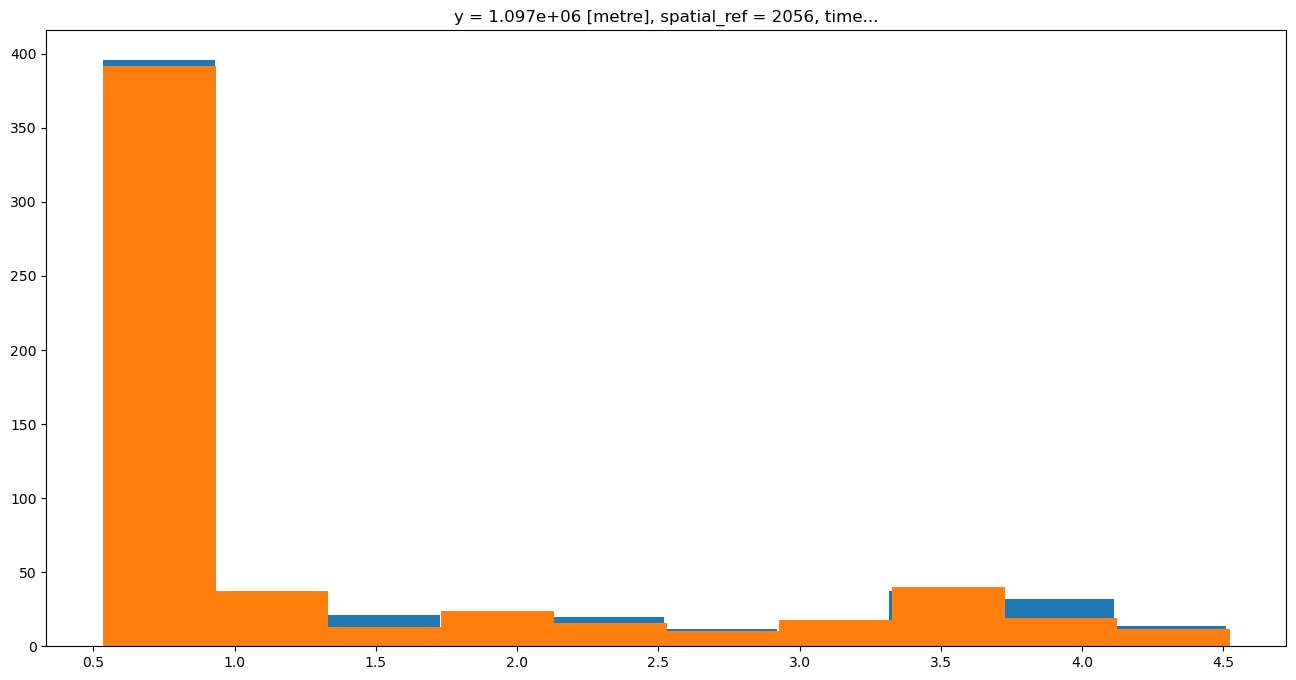

In [47]:
G[1].plot.hist()
G[0].plot.hist()

# but there are 2 arrays? how?

If there would be an outlier, this would either throw an error message, telling us that the data range reaches infinity. Other problems could be (if you load the dataset with the argument `scale_offset` that some division causes artifacts with e.g. negative values. In the text output (directly below the executed cell), you can see the bin breaks. If you have negative values they will show up there.

In case you will encounter the infinity error or strange automatic bin breaks, there is a solution below. 

- First, remove all values that have the value "infinte" and then try to plot the histogram again.
- Keep only values bigger `x_low` (`x_low` would be your lower threshold value)
- Keep only values small `x_hig` (`x_hig` would be your upper threshold value)

In [48]:
G = G.where(np.isfinite(G))  # Set all values that are not finite to NaN (Not a Number)
G = G.where((G>=0) & (G<=100),np.nan)  # Set all values that are not finite to NaN (Not a Number)

(array([ 98591., 104806.,  23924.,  20735.,  18453.,  21124.,  16825.,
         10018.,   2855.,    222.]),
 array([0.09645613, 0.74454135, 1.39262664, 2.04071188, 2.688797  ,
        3.33688211, 3.98496747, 4.63305283, 5.28113794, 5.92922306,
        6.57730865]),
 <BarContainer object of 10 artists>)

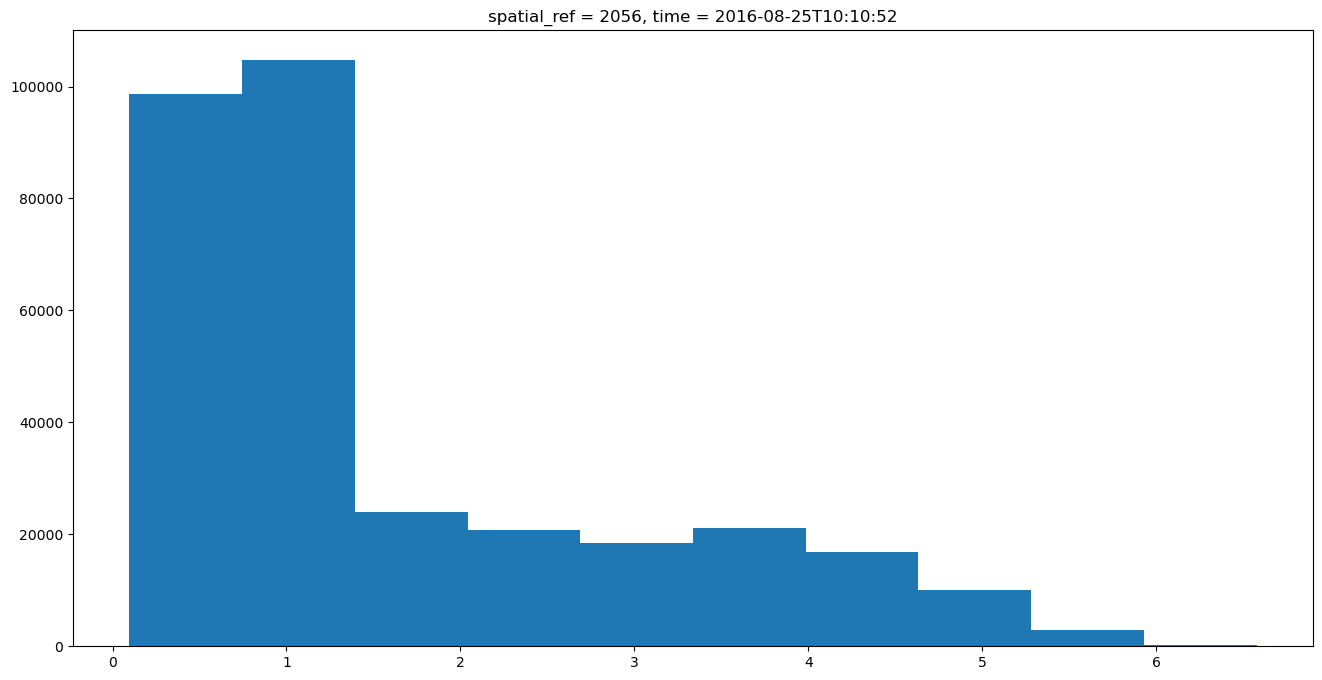

In [49]:
G.plot.hist( )

This works but there are situation where we might want to have more control on how exactly a histogram is plotted. For example: 

* Let's change the range of values shown in the histogram of G
* Let's increase the number of bins in the histogram

(array([     0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0., 242685.,
         68220.,   6648.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.]),
 array([-50. , -47.5, -45. , -42.5, -40. , -37.5, -35. , -32.5, -30. ,
        -27.5, -25. , -22.5, -20. , -17.5, -15. , -12.5, -10. ,  -7.5,
         -5. ,  -2.5,   0. ,   2.5,   5. ,   7.5,  10. ,  12.5,  15. ,
         17.5,  20. ,  22.5,  25. ,  27.5,  30. ,  32.5,  35. ,  37.5,
         40. ,  42.5,  45. ,  47.5,  50. ]),
 <BarContainer object of 40 artists>)

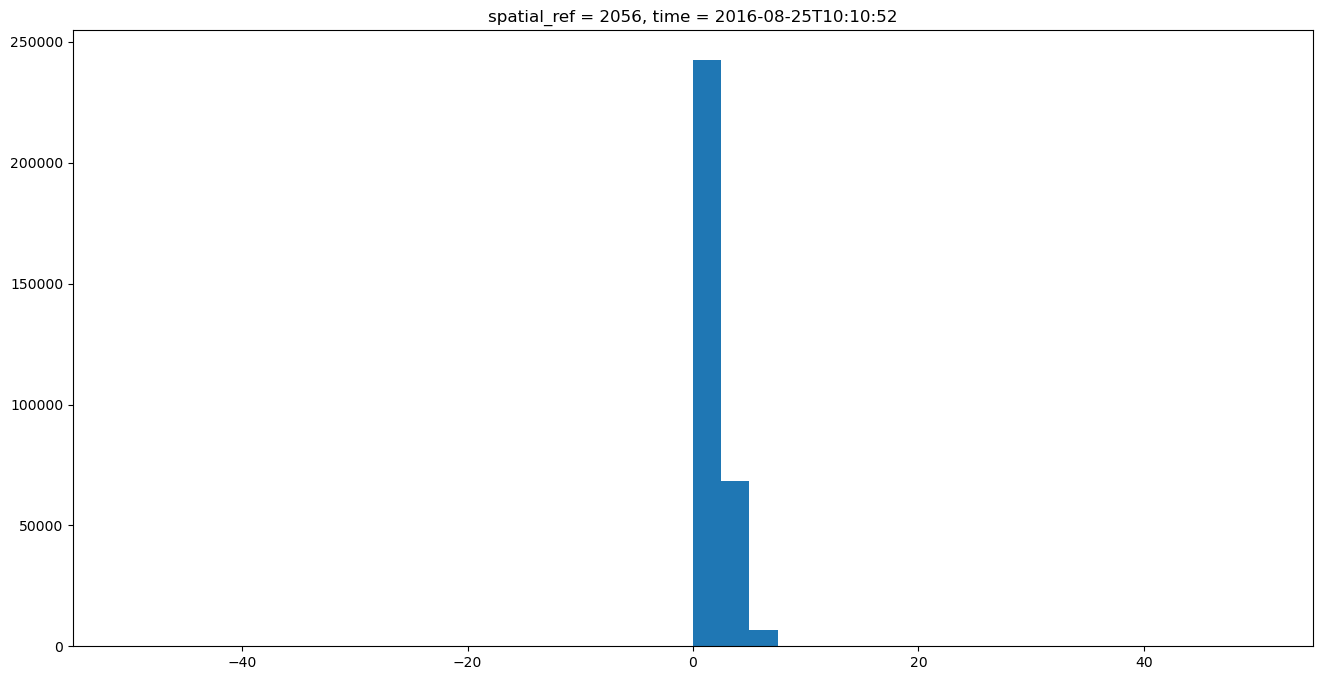

In [50]:
G.plot.hist(bins=40, range=(-50, 50))  
# We added the "bin" keyword that allows specifying the number of bins to be used

(array([     0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0., 242685.,
         68220.,   6648.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.]),
 array([-50. , -47.5, -45. , -42.5, -40. , -37.5, -35. , -32.5, -30. ,
        -27.5, -25. , -22.5, -20. , -17.5, -15. , -12.5, -10. ,  -7.5,
         -5. ,  -2.5,   0. ,   2.5,   5. ,   7.5,  10. ,  12.5,  15. ,
         17.5,  20. ,  22.5,  25. ,  27.5,  30. ,  32.5,  35. ,  37.5,
         40. ,  42.5,  45. ,  47.5,  50. ]),
 <BarContainer object of 40 artists>)

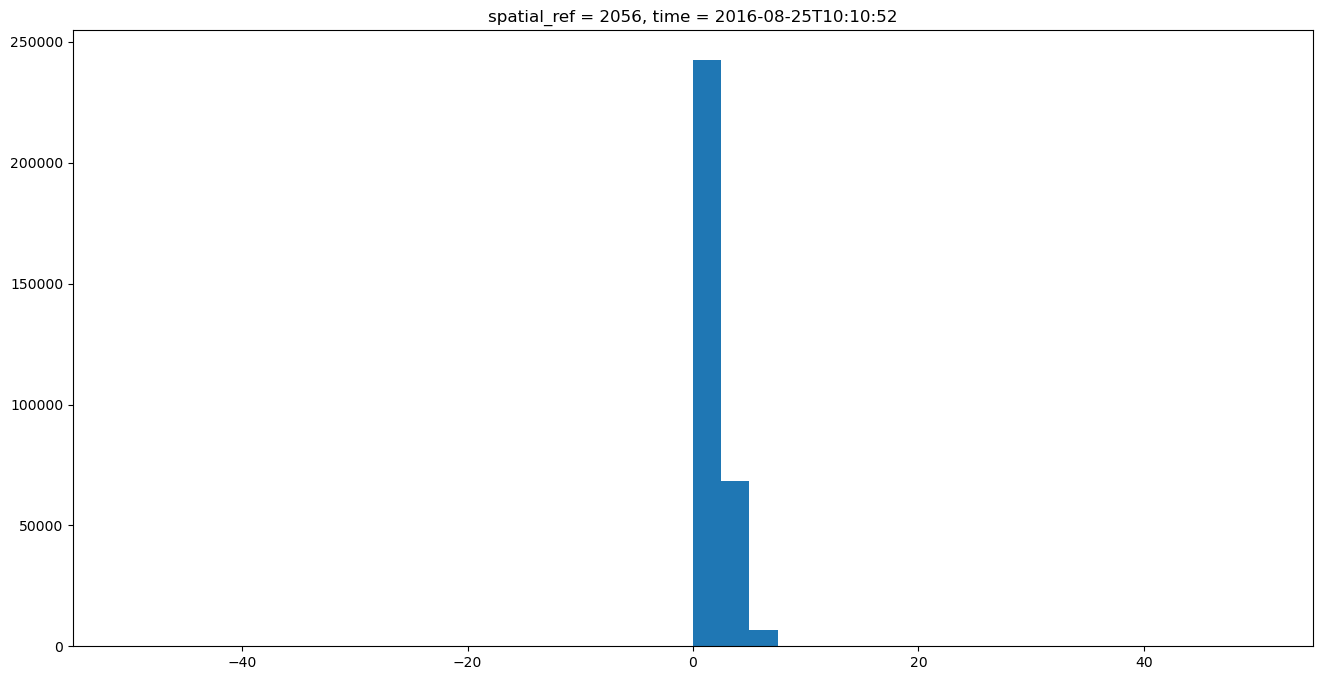

In [51]:
dix, ax = plt.subplots(ncols=1, nrows=1)
G.plot.hist(bins=40, range=(-50, 50))  

# this example is not in here yet 

This is not perfect yet, e.g. there is no need to visualize all the absence of data on the left-hand side. <span class='dothis'>Adjust the parameters in the plotting command above so you achieve an optimal visualization.</span>

### Selecting the threshold value for glacier mapping

Now to the actual glacier mapping. <span class='dothis'>As we did in QGIS, we will define a threshold to distinguish between glaciers (where <i>G > threshold</i>) and non-glacierized terrain (<i>G < threshold</i>).</span>

We can directly test whether the threshold is appropriate by plotting the scene, but this time telling the program to use discrete colors for all values that are within intervals that we define with the `levels` keyword. Note that we need to define at least two values for `levels`. We simply chose the first one very low, outside the range of data values.



In [52]:
# here we set the threshold - CHANGE THIS TO VARY THE THRESHOLD!
threshold = 1.8

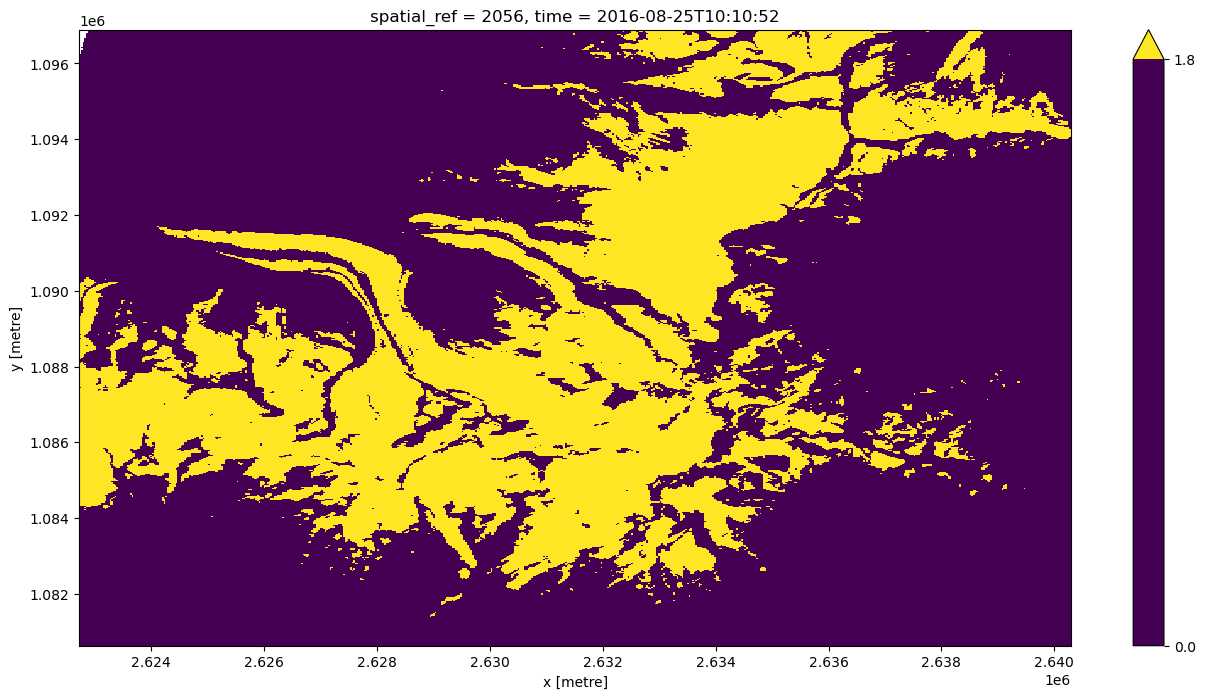

In [53]:
# Using the "levels" keyword which allows specifying the boundaries 
# between discrete classes for plotting. 
G.plot(levels=[0, threshold])  
# Here the resulting classes are 
#   (1) smaller -100, 
#   (2) between -100 and "threshold", 
#   (3) larger than "Trheshold"

This plot now shows all grid cell with values between -100 and "threshold" in one colour, all grid cells with values > threshold in another colour.

This is excellent, **but has the disadvantage that we have no comparison with the original scene, to be able to assess how accurately our chosen threshold distinguishes glaciers from non-glacierized terrain.**

We thus go more fancy and **plot the above threshold map *and* a false color composite of the original scene on top of each other.** We do this by simply calling the `plot()` function twice, the two graphics will then be plotted into the same figure. Furthermore, we use the `alpha` parameter to define how transparent the threshold map should be (`alpha = 0` fully transparent, `alpha = 1` fully opaque).

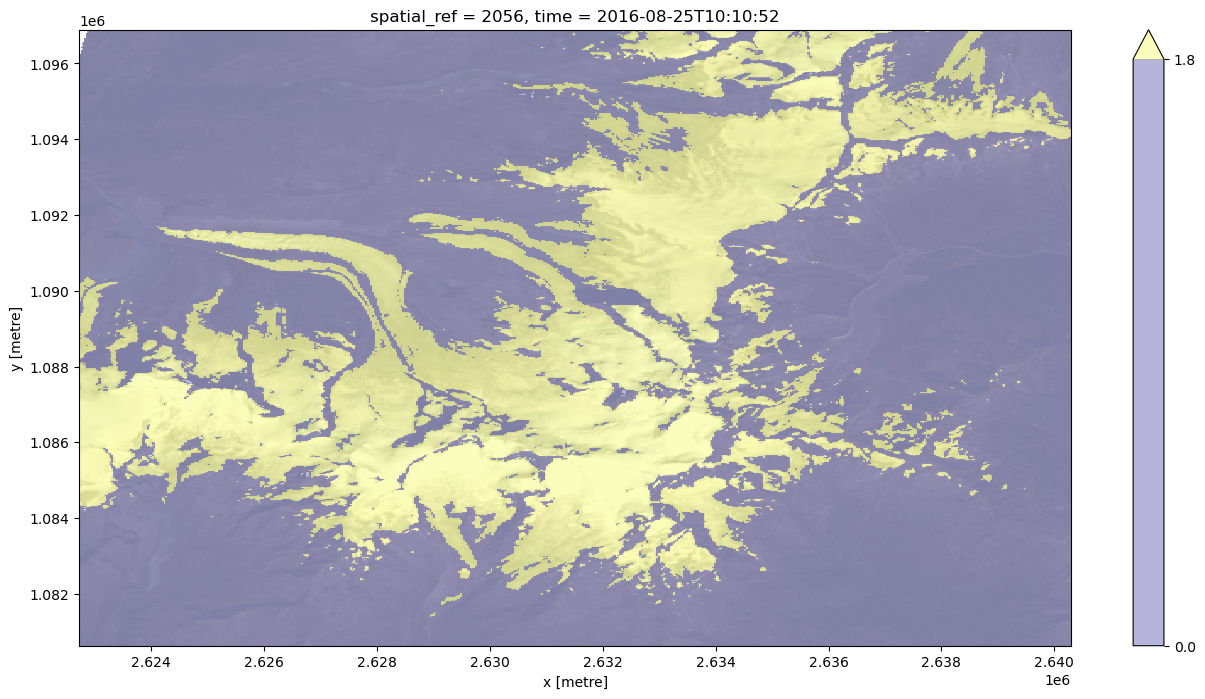

In [54]:
mosaic[['red','green','blue']].to_array().plot.imshow(robust=True, alpha=.3)
G.plot(levels=[0, threshold], alpha=0.3, cmap='plasma')


With these tools at hand, <span class='dothis'>vary the threshold to find an optimal treshold value.</span>

### Basic statistics

**Now to some very basic statistics: How many percent of the chosen satellite image are glacier covered?**

We calculate this by taking the number of glacierized grid cells `(G.where(G > threshold)).count()` and divide them by the total number of grid cells `G.count()`. The result is again a xr.DataArray which contains just the value.

In [55]:
100 * (G.where(G > threshold)).count() / G.count()

<xarray.DataArray ()> Size: 8B
array(31.58181469)
Coordinates:
    spatial_ref  int32 4B 2056
    time         datetime64[ns] 8B 2016-08-25T10:10:52

In [56]:
(100 * (G.where(G > threshold)).count() / G.count()).values     
# adding .values to an xarray returns just the values of the array inside it --> 41.9 %

array(31.58181469)

### Export the results

After we found an optimal threshold value, let's now create an array where all glacier grid cells have the value 1, and all non-glacierized cells have the value 0.

We do this by using the `xr.where()` function. Its syntax is `xr.where(condition, value to use where condition is True, value to use where condition is False)`.

In [57]:
G

<xarray.DataArray (y: 542, x: 586)> Size: 1MB
array([[       nan,        nan,        nan, ..., 0.5887792 , 0.5907379 ,
        0.6000356 ],
       [       nan,        nan,        nan, ..., 0.5837373 , 0.6010728 ,
        0.6080667 ],
       [       nan,        nan,        nan, ..., 0.59947824, 0.60255426,
        0.59720844],
       ...,
       [0.5888313 , 0.5936995 , 0.598757  , ..., 0.5761593 , 0.57073325,
        0.58191335],
       [0.5629139 , 0.60139316, 0.59930086, ..., 0.56888443, 0.5641159 ,
        0.5691832 ],
       [0.5776621 , 0.5947975 , 0.5966881 , ..., 0.56389296, 0.55623114,
        0.56847286]], shape=(542, 586), dtype=float32)
Coordinates:
  * y            (y) float64 4kB 1.097e+06 1.097e+06 ... 1.081e+06 1.081e+06
  * x            (x) float64 5kB 2.623e+06 2.623e+06 ... 2.64e+06 2.64e+06
    spatial_ref  int32 4B 2056
    time         datetime64[ns] 8B 2016-08-25T10:10:52

In [58]:
glacier = xr.where(G > threshold, 1, 0)
glacier

<xarray.DataArray (y: 542, x: 586)> Size: 3MB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(542, 586))
Coordinates:
  * y            (y) float64 4kB 1.097e+06 1.097e+06 ... 1.081e+06 1.081e+06
  * x            (x) float64 5kB 2.623e+06 2.623e+06 ... 2.64e+06 2.64e+06
    spatial_ref  int32 4B 2056
    time         datetime64[ns] 8B 2016-08-25T10:10:52

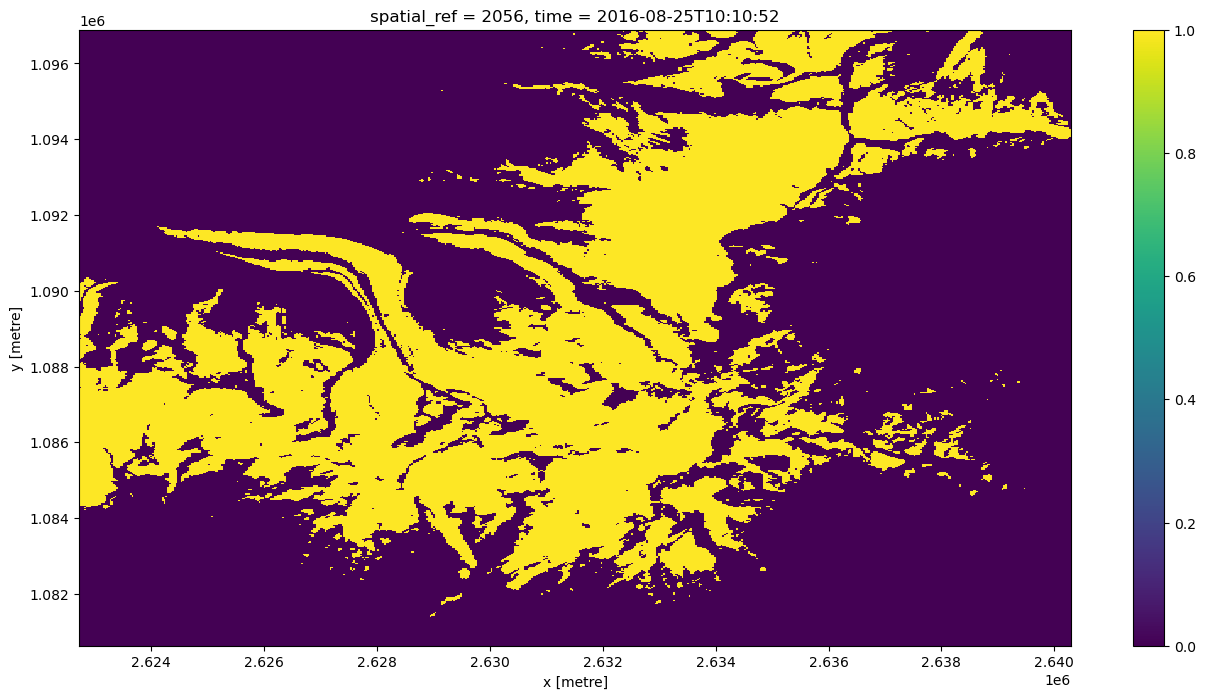

In [59]:
glacier.plot()  # plt it once again to see whether the result is what we want

<span class='dothis'>If everything looks fine, then it is now time to export our glacier map. We do this by using the function `rio.to_raster()`.</span>

Note that our xr.DataArray named *glacier* is of the data type `int32` (= 32 bit integer). The export function cannot handle this data type. Thus we convert *glacier* to data type `int16` (16 bit integer) during export by using `glacier.astype('int16')`.

This makes a 'GeoTIFF' file which can be loaded into software like QGIS or ArcGIS. Note that GeoTIFFs are not properly understood by programs like Photos or Photoshop, so they will look quite strange if they open at all!

In [60]:
glacier.astype('int16').rio.to_raster("glacier_map.tif")

In [61]:
client.close()
# to save pc memory 